<a href="https://colab.research.google.com/github/yGifoom/ACSAI-Notes/blob/main/DeepLearningKaggleCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2 as transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.model_selection import KFold
import joblib
from copy import deepcopy

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

cudnn.benchmark = True
plt.ion()

In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')
zip_ref = zipfile.ZipFile("/content/drive/My Drive/ACSAI/Kaggle_competition/dl2425_challenge_dataset.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

best_model_path = "/content/drive/MyDrive/ACSAI/Kaggle_competition/best_models"

Mounted at /content/drive/


In [3]:
# HYPER
batch_s = 32
learning_r = 0.001
epochs = 40
mean, std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
# or imagenet mean and std: mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
# our dataset mean and std: torch.tensor([0.4484, 0.3985, 0.3457]),torch.tensor([0.2575, 0.2434, 0.2617])

In [ ]:
# CALCULATE MEAN AND STD OF DATASET
data_dir = '/content/dl2425_challenge_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transforms.ToTensor(),) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_s,
              shuffle=True, num_workers=2) for x in ['train', 'val']}
mean = 0
std = 0
i = 0
for k in dataloaders:
  for images, _ in dataloaders[k]:
    mean = (mean*i*batch_s + images.mean(axis=(0, 2, 3))*batch_s)/((i+1)*batch_s)
    std = ((i*batch_s*(std**2)+batch_s*(images.std(axis=(0, 2, 3))**2))/((i+1)*batch_s))**.5
    i += 1

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandAugment(fill = list(mean*255)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content/dl2425_challenge_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_s,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4484, 0.3985, 0.3457])
    std = np.array([0.2575, 0.2434, 0.2617])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


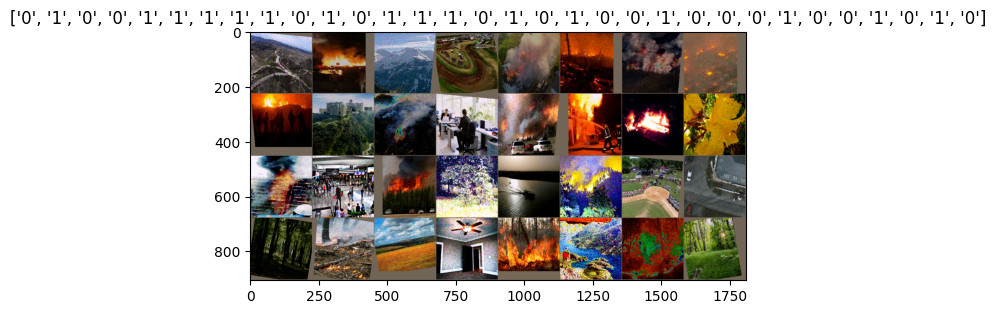

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(name, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    tempdir = "/content/drive/MyDrive/ACSAI/Kaggle_competition/best_models"
    best_model_params_path = os.path.join(tempdir, f'{name}_best__params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def train_model_kfold(name, model, criterion, optimizer, scheduler, num_epochs=15, k=10):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    tempdir = "/content/drive/MyDrive/ACSAI/Kaggle_competition/best_models"
    best_model_params_path = os.path.join(tempdir, f'{name}_best__params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    kf = KFold(n_splits=k, shuffle=True, random_state=42) # Initialize KFold
    fold_accuracies = []


    for fold, (train_index, val_index) in enumerate(kf.split(image_datasets['train'])):
        print(f"Fold {fold + 1}/{k}")

        # Create data loaders for current fold
        train_subset = torch.utils.data.Subset(image_datasets['train'], train_index)
        val_subset = torch.utils.data.Subset(image_datasets['train'], val_index)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_s, shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_s, shuffle=False, num_workers=4)

        # Reset model weights for each fold
        model.load_state_dict(torch.load(best_model_params_path)) # load initial weights

        # Replace dataloaders in the training loop with the fold-specific loaders
        dataloaders_fold = {'train': train_loader, 'val': val_loader}
        dataset_sizes_fold = {'train': len(train_subset), 'val': len(val_subset)}


        # Train for specified epochs for current fold
        for epoch in range(num_epochs):
          print(f'Epoch {epoch}/{num_epochs - 1}')
          print('-' * 10)

          # Each epoch has a training and validation phase
          for phase in ['train', 'val']:
              if phase == 'train':
                  model.train()  # Set model to training mode
              else:
                  model.eval()   # Set model to evaluate mode

              running_loss = 0.0
              running_corrects = 0

              # Iterate over data.
              for inputs, labels in dataloaders[phase]:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)
              if phase == 'train':
                  scheduler.step()

              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]

              print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  torch.save(model.state_dict(), best_model_params_path)

          print()

        # Keep track of accuracies for each fold.
        fold_accuracies.append(best_acc)

    print(f"Average accuracy across {k} folds: {np.mean(fold_accuracies)}")
    return model


# approccio full training resnet 18

In [13]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 15 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

In [15]:
name = f"resnet18_bs{batch_s}_lr{learning_r}_tms{int(time.time())}_transform_randaugment"
model_ft = train_model(name, model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)
# pretty good validation: 0.987852, 24 epochs

Epoch 0/29
----------
train Loss: 0.2168 Acc: 0.9203
val Loss: 0.0695 Acc: 0.9821

Epoch 1/29
----------
train Loss: 0.1078 Acc: 0.9633
val Loss: 0.0564 Acc: 0.9824

Epoch 2/29
----------
train Loss: 0.0881 Acc: 0.9688
val Loss: 0.0517 Acc: 0.9821

Epoch 3/29
----------
train Loss: 0.0646 Acc: 0.9792
val Loss: 0.0487 Acc: 0.9827

Epoch 4/29
----------
train Loss: 0.0591 Acc: 0.9806
val Loss: 0.0465 Acc: 0.9850

Epoch 5/29
----------
train Loss: 0.0574 Acc: 0.9799
val Loss: 0.0432 Acc: 0.9863

Epoch 6/29
----------
train Loss: 0.0472 Acc: 0.9848
val Loss: 0.0428 Acc: 0.9869

Epoch 7/29
----------
train Loss: 0.0374 Acc: 0.9887
val Loss: 0.0460 Acc: 0.9866

Epoch 8/29
----------
train Loss: 0.0388 Acc: 0.9880
val Loss: 0.0465 Acc: 0.9866

Epoch 9/29
----------
train Loss: 0.0362 Acc: 0.9884
val Loss: 0.0463 Acc: 0.9875

Epoch 10/29
----------
train Loss: 0.0322 Acc: 0.9898
val Loss: 0.0463 Acc: 0.9879

Epoch 11/29
----------
train Loss: 0.0319 Acc: 0.9894
val Loss: 0.0431 Acc: 0.9891

Ep

In [ ]:
#further fine tuning for resnet18
# Load parameters from the best_parameters folder
best_parameters_path = "/content/drive/MyDrive/ACSAI/Kaggle_competition/best_models"  # Replace with the actual path

# Assuming the best parameters are saved as 'best_params.pt' (or a similar name)
# Adjust the filename if needed
best_params_file = os.path.join(best_parameters_path, f'resnet18_bs32_lr0.001_tms1733608835_transform_randaugment_best__params.pt')

if os.path.exists(best_params_file):
    # Load the best model parameters
    model_ft.load_state_dict(torch.load(best_params_file))
    print("Loaded best parameters from:", best_params_file)
else:
    print("Best parameters file not found:", best_params_file)
    print("Training model from scratch.")


# Lower the learning rate (example: reduce by a factor of 10)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_r*.1, momentum=0.9)

# Continue with the training loop
name = f"resnet18_bs{batch_s}_lr{learning_r}_tms{int(time.time())}_transform_randaugment_fine"
model_ft = train_model_kfold(name, model_ft, criterion, optimizer_ft, exp_lr_scheduler)

<ipython-input-16-e6aa9e9c871e>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(best_params_file))


Loaded best parameters from: /content/drive/MyDrive/ACSAI/Kaggle_competition/best_models/resnet18_bs32_lr0.001_tms1733608835_transform_randaugment_best__params.pt
Fold 1/10
Epoch 0/14
----------


<ipython-input-15-b47e2aa89ba8>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path)) # load initial weights


train Loss: 0.0221 Acc: 0.9926
val Loss: 0.0472 Acc: 0.9888

Epoch 1/14
----------
train Loss: 0.0207 Acc: 0.9927
val Loss: 0.0536 Acc: 0.9859

Epoch 2/14
----------
train Loss: 0.0237 Acc: 0.9923
val Loss: 0.0470 Acc: 0.9885

Epoch 3/14
----------
train Loss: 0.0238 Acc: 0.9917
val Loss: 0.0474 Acc: 0.9879

Epoch 4/14
----------
train Loss: 0.0218 Acc: 0.9922
val Loss: 0.0547 Acc: 0.9850

Epoch 5/14
----------
train Loss: 0.0217 Acc: 0.9936
val Loss: 0.0511 Acc: 0.9859

Epoch 6/14
----------
train Loss: 0.0183 Acc: 0.9946
val Loss: 0.0494 Acc: 0.9879

Epoch 7/14
----------
train Loss: 0.0177 Acc: 0.9946
val Loss: 0.0532 Acc: 0.9859

Epoch 8/14
----------
train Loss: 0.0176 Acc: 0.9946
val Loss: 0.0494 Acc: 0.9882

Epoch 9/14
----------
train Loss: 0.0204 Acc: 0.9929
val Loss: 0.0489 Acc: 0.9866

Epoch 10/14
----------
train Loss: 0.0167 Acc: 0.9945
val Loss: 0.0492 Acc: 0.9888

Epoch 11/14
----------
train Loss: 0.0204 Acc: 0.9926
val Loss: 0.0524 Acc: 0.9872

Epoch 12/14
----------
t

KeyboardInterrupt: 

# resnet 18 feature extraction + random forest

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
#model_ft.load_state_dict(torch.load("/content/drive/MyDrive/ACSAI/Kaggle_competition/best_models/resnet18_tms1733404813_best__params.pt", weights_only=True))

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, batch_labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.extend(outputs.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())
    return np.array(features), np.array(labels)


# Extract features using the pre-trained ResNet18
model_ft.fc = nn.Identity() # Remove the classification layer
model_ft.eval()
train_features, train_labels = extract_features(model_ft, dataloaders['train'])
val_features, val_labels = extract_features(model_ft, dataloaders['val'])


# Train a Random Forest classifier on the extracted features

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) # You can adjust hyperparameters
best_acc = 0.0
for i in range(epochs):
  rf_classifier.fit(train_features, train_labels)
  # Make predictions on the validation set
  val_predictions = rf_classifier.predict(val_features)
  # Evaluate the Random Forest model
  val_accuracy = accuracy_score(val_labels, val_predictions)
  print(f"Validation Accuracy epoch:{i}/{epochs}: {val_accuracy}")

  if val_accuracy > best_acc:
    best_acc = val_accuracy
    best_rf_classifier = deepcopy(rf_classifier)

# save the classifier
try:
  with open("/content/drive/MyDrive/ACSAI/Kaggle_competition/best_models/rf.pkl", 'wb') as fid:
    joblib.dump(best_rf_classifier, fid)
except Exception as e:
  print(f"upsie, excpetion {e}")

Validation Accuracy epoch:0/15: 0.960997442455243
Validation Accuracy epoch:1/15: 0.960997442455243
Validation Accuracy epoch:2/15: 0.960997442455243


KeyboardInterrupt: 

In [ ]:

# save the classifier
with open("/content/drive/MyDrive/ACSAI/Kaggle_competition/best_models/rf.pkl", 'wb') as fid:
    joblib.dump(best_rf_classifier, fid)

# resnet 50 transfer learning

In [ ]:
model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=learning_r, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
name = f"resnet50_b{batch_s}_tms{int(time.time())}"
model_conv = train_model(name, model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25) #actual shit tops at .9564 epoch 13

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2797 Acc: 0.8939
val Loss: 0.1545 Acc: 0.9473

Epoch 1/24
----------
train Loss: 0.2166 Acc: 0.9160
val Loss: 0.1380 Acc: 0.9568

Epoch 2/24
----------
train Loss: 0.2033 Acc: 0.9226
val Loss: 0.1427 Acc: 0.9511

Epoch 3/24
----------
train Loss: 0.1974 Acc: 0.9276
val Loss: 0.1251 Acc: 0.9626

Epoch 4/24
----------
train Loss: 0.1950 Acc: 0.9262
val Loss: 0.1211 Acc: 0.9623

Epoch 5/24
----------
train Loss: 0.1906 Acc: 0.9260
val Loss: 0.1240 Acc: 0.9613

Epoch 6/24
----------
train Loss: 0.1839 Acc: 0.9289
val Loss: 0.1125 Acc: 0.9639

Epoch 7/24
----------
train Loss: 0.1883 Acc: 0.9290
val Loss: 0.1137 Acc: 0.9636

Epoch 8/24
----------
train Loss: 0.1783 Acc: 0.9340
val Loss: 0.1126 Acc: 0.9629

Epoch 9/24
----------
train Loss: 0.1805 Acc: 0.9340
val Loss: 0.1124 Acc: 0.9629

Epoch 10/24
----------
train Loss: 0.1743 Acc: 0.9372
val Loss: 0.1109 Acc: 0.9645

Epoch 11/24
----------
train Loss: 0.1891 Acc: 0.9267
val Loss: 0.1076 Acc: 0.9658

Epoch 12/24
----------
t

KeyboardInterrupt: 

# DENSENET

In [ ]:
class DenseNetCustom(nn.Module):
    def __init__(self, num_classes=1000):
        super(DenseNetCustom, self).__init__()
        # Using a pre-trained DenseNet-121
        self.densenet = models.densenet121(pretrained=True)
        for parameter in self.densenet.parameters():
          parameter.requires_grad=False
        # Adjust the classifier to match the number of classes
        self.densenet.classifier = nn.Linear(1024, num_classes)
        self.densenet.classifier.requires_grad_ = True

    def forward(self, x):
        x = self.densenet(x)
        return x


# Example usage
model_conv = DenseNetCustom(num_classes=2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.densenet.classifier.parameters(), lr=learning_r, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 124MB/s]


In [ ]:
name = f"dense_b{batch_s}_lr{learning_r}_{int(time.time())}"
model_conv = train_model(name, model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=epochs)

Epoch 0/39
----------
train Loss: 4.0999 Acc: 0.8732
val Loss: 1.8140 Acc: 0.9428

Epoch 1/39
----------
train Loss: 2.6125 Acc: 0.9068
val Loss: 1.9184 Acc: 0.9258

Epoch 2/39
----------
train Loss: 2.3782 Acc: 0.9154
val Loss: 1.0403 Acc: 0.9652

Epoch 3/39
----------
train Loss: 2.6493 Acc: 0.9111
val Loss: 1.5979 Acc: 0.9399

Epoch 4/39
----------
train Loss: 2.0246 Acc: 0.9213
val Loss: 1.0391 Acc: 0.9568

Epoch 5/39
----------
train Loss: 2.8682 Acc: 0.9050
val Loss: 1.1756 Acc: 0.9626

Epoch 6/39
----------
train Loss: 3.0680 Acc: 0.9164
val Loss: 1.4769 Acc: 0.9527

Epoch 7/39
----------
train Loss: 1.6968 Acc: 0.9398
val Loss: 1.3343 Acc: 0.9549

Epoch 8/39
----------
train Loss: 1.6278 Acc: 0.9361
val Loss: 1.1433 Acc: 0.9623

Epoch 9/39
----------
train Loss: 1.3706 Acc: 0.9431
val Loss: 1.1008 Acc: 0.9629

Epoch 10/39
----------
train Loss: 1.4008 Acc: 0.9401
val Loss: 1.0941 Acc: 0.9645

Epoch 11/39
----------
train Loss: 1.2009 Acc: 0.9419
val Loss: 1.0489 Acc: 0.9620

Ep

KeyboardInterrupt: 